<a href="https://colab.research.google.com/github/Sachin44-ux/Project-4/blob/main/liv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn catboost xgboost lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=927f68e9e50961f8af9659f56af0c193aafcec64ec05043fc6ad34c17ed86ce4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_curve,roc_auc_score
import seaborn as sns
import shap
import lime.lime_tabular
import pickle
import matplotlib.pyplot as plt

In [ ]:
# Load Liver Disease Dataset
df = pd.read_csv("/content/Liver_disease_data.csv")

In [ ]:
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


In [ ]:
df.describe()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,50.394118,0.504118,27.699801,9.832309,0.291765,0.521765,5.000993,0.142353,0.154706,59.863867,0.550588
std,17.641915,0.500130,7.210400,5.757472,0.454708,0.666262,2.847074,0.349515,0.361730,22.996262,0.497581
min,20.000000,0.000000,15.004710,0.003731,0.000000,0.000000,0.001852,0.000000,0.000000,20.019254,0.000000
25%,35.000000,0.000000,21.455414,4.841811,0.000000,0.000000,2.622121,0.000000,0.000000,40.024216,0.000000
50%,51.000000,1.000000,27.925367,9.828195,0.000000,0.000000,5.022883,0.000000,0.000000,59.513146,1.000000
75%,66.000000,1.000000,33.957668,14.871671,1.000000,1.000000,7.401642,0.000000,0.000000,79.428755,1.000000
max,80.000000,1.000000,39.992845,19.952456,1.000000,2.000000,9.994964,1.000000,1.000000,99.991413,1.000000


In [ ]:
df.isnull().sum()

,0
Age,0
Gender,0
BMI,0
AlcoholConsumption,0
Smoking,0
GeneticRisk,0
PhysicalActivity,0
Diabetes,0
Hypertension,0
LiverFunctionTest,0


In [ ]:
df.shape

(1700, 11)

In [ ]:
df['Diagnosis'].value_counts()

,count
Diagnosis,
1,936
0,764


In [ ]:
# Separate features and target
X = df.drop('Diagnosis', axis=1)  # Update 'target' column name if different
y = df['Diagnosis']

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('Diagnosis', axis=1), df['Diagnosis'])

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Standardizing numeric columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [ ]:
# Define base models
base_learners = [
('gbm', GradientBoostingClassifier(n_estimators=120,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=8,
    subsample=0.6,
    max_features='log2',
    random_state=42)),
('cat'  ,CatBoostClassifier(iterations=100,          # Number of boosting rounds
    learning_rate=0.05,      # Slower learning = better generalization
    depth=6,                 # Depth of trees
    random_state=42,
    verbose=0)),
('ada'  ,AdaBoostClassifier(  n_estimators=1000,        # Number of weak learners
    learning_rate=0.09,      # Smaller step size for better generalization
    random_state=42)),
                  ]

In [ ]:

from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(
    n_estimators=120,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=8,
    subsample=0.6,
    max_features='log2',
    random_state=42
)

gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features='log2',
                           min_samples_leaf=8, min_samples_split=20,
                           n_estimators=120, random_state=42, subsample=0.6)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred_test = gbm.predict(X_test)

# Evaluate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the training set for training accuracy
y_pred_train = gbm.predict(X_train)

# Evaluate training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")


Test Accuracy: 0.9118
Training Accuracy: 0.9721


In [ ]:
cat = CatBoostClassifier(
    iterations=100,          # Number of boosting rounds
    learning_rate=0.05,      # Slower learning = better generalization
    depth=6,                 # Depth of trees
    random_state=42,
    verbose=0                # Suppress logs (set to 100 if you want progress printed)
)

cat.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred_test = cat.predict(X_test)

# Evaluate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the training set for training accuracy
y_pred_train = cat.predict(X_train)

# Evaluate training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

Test Accuracy: 0.9118
Training Accuracy: 0.9434


In [ ]:
ada = AdaBoostClassifier(
    n_estimators=1000,        # Number of weak learners
    learning_rate=0.05,      # Smaller step size for better generalization
    random_state=42
)

ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.05, n_estimators=1000, random_state=42)

In [ ]:
# Predict on the test set
y_pred_test = ada.predict(X_test)

# Evaluate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the training set for training accuracy
y_pred_train = ada.predict(X_train)

# Evaluate training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

Test Accuracy: 0.9176
Training Accuracy: 0.9243


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

# Define meta-learner
meta_learner = RandomForestClassifier(n_estimators=600, random_state=42)

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, passthrough=True,cv=5)

In [ ]:
# Train the model
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('gbm',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=6,
                                                           max_features='log2',
                                                           min_samples_leaf=8,
                                                           min_samples_split=20,
                                                           n_estimators=120,
                                                           random_state=42,
                                                           subsample=0.6)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7fbc55385650>),
                               ('ada',
                                AdaBoostClassifier(learning_rate=0.09,
                                                   n_estimators=1000,
                                                   random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=600,
                                                          random_state=42),
                   passthrough=True)

In [ ]:
# Predictions
y_pred = stacking_model.predict(X_test)

In [ ]:
train_accuracy = accuracy_score(y_train, stacking_model.predict(X_train))
test_accuracy = accuracy_score(y_test, stacking_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9596
Testing Accuracy: 0.9353


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Optional: Create a directory to save plots
os.makedirs("plots", exist_ok=True)

# Histogram for all numeric columns
df.hist(bins=15, figsize=(15, 10), color='skyblue')
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.savefig("plots/histogram_features.png", bbox_inches='tight')
plt.close()

In [ ]:
# Boxplot for all numeric columns
plt.figure(figsize=(15, 6))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title("Boxplot of Numeric Features")
plt.xticks(rotation=45)
plt.savefig("plots/boxplot_numeric_features.png", bbox_inches='tight')
plt.close()

In [ ]:
# Bar plot for target distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Diagnosis', palette='Set2')
plt.title("Diagnosis Class Distribution")
plt.savefig("plots/diagnosis_distribution.png", bbox_inches='tight')
plt.close()

<ipython-input-32-d4aa405c0e02>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Diagnosis', palette='Set2')


In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig("plots/feature_correlation_heatmap.png", bbox_inches='tight')
plt.close()

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("plots/confusion_matrix_heatmap.png", bbox_inches='tight')
plt.close()

In [ ]:
# ROC Curve for CatBoost
y_prob = cat.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.savefig("plots/roc_curve_catboost.png", bbox_inches='tight')
plt.close()

NameError: name 'roc_curve' is not defined

In [ ]:


# Accuracy comparison of all models
models = ['GradientBoosting', 'CatBoost', 'AdaBoost', 'Stacking']
accuracies = [
    accuracy_score(y_test, gbm.predict(X_test)),
    accuracy_score(y_test, cat.predict(X_test)),
    accuracy_score(y_test, ada.predict(X_test)),
    accuracy_score(y_test, stacking_model.predict(X_test))
]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0.8, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.savefig("plots/model_accuracy_comparison.png", bbox_inches='tight')
plt.close()


In [ ]:
# Class distribution comparison before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=df['Diagnosis'], ax=axes[0], palette='Set1')
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Diagnosis")

# After SMOTE
sns.countplot(x=y_resampled, ax=axes[1], palette='Set2')
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Diagnosis")

plt.tight_layout()
plt.savefig("plots/class_distribution_comparison_smote.png", bbox_inches='tight')
plt.close()



<ipython-input-38-0d0e95297aea>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Diagnosis'], ax=axes[0], palette='Set1')
<ipython-input-38-0d0e95297aea>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette='Set2')


In [ ]:
# Gradient Boosting Feature Importance
importances = gbm.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance Score")
plt.savefig("plots/gbm_feature_importance.png", bbox_inches='tight')
plt.close()

# ---------------------------
# CatBoost Feature Importance
cat_importances = cat.get_feature_importance()
feature_names = X_train.columns

cat_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(cat_feat_imp_df['Feature'], cat_feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.savefig("plots/catboost_feature_importance.png", bbox_inches='tight')
plt.close()

# ---------------------------
# AdaBoost Feature Importance
importances = ada.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances)
plt.title("AdaBoost Feature Importance")
plt.xlabel("Importance Score")
plt.savefig("plots/adaboost_feature_importance.png", bbox_inches='tight')
plt.close()

In [ ]:
from sklearn.inspection import permutation_importance


In [ ]:
# Compute permutation importance for stacking model
result = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)

# Convert to pandas series
importances = pd.Series(result.importances_mean, index=X_test.columns)

# Plot
plt.figure(figsize=(10, 6))
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance - Stacked Model (Permutation)')
plt.xlabel("Mean Decrease in Accuracy")
plt.tight_layout()
plt.savefig("plots/stacking_model_permutation_importance.png", bbox_inches='tight')
plt.close()

In [ ]:
# Define dictionary of models and names
model_dict = {
    "Gradient Boosting": gbm,
    "CatBoost": cat,
    "AdaBoost": ada,
    "Stacking": stacking_model
}

# Store results
model_results = []

for name, model in model_dict.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    model_results.append((name, acc, auc_score))
    print(f"{name:<20} | Accuracy: {acc:.4f} | AUC: {auc_score:.4f}")



Gradient Boosting    | Accuracy: 0.9118 | AUC: 0.9592
CatBoost             | Accuracy: 0.9118 | AUC: 0.9664
AdaBoost             | Accuracy: 0.9176 | AUC: 0.9614
Stacking             | Accuracy: 0.9353 | AUC: 0.9682


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title("📊 Confusion Matrix - Stacking Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("plots/stacking_confusion_matrix.png", bbox_inches='tight')
plt.close()

<ipython-input-47-242f51895836>:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-47-242f51895836>:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/stacking_confusion_matrix.png", bbox_inches='tight')


In [ ]:
# Get probabilities for the positive class (Disease = 1)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('📈 ROC Curve - Stacking Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/stacking_model_roc_curve.png", bbox_inches='tight')
plt.close()

<ipython-input-48-036e5bff3c2f>:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-036e5bff3c2f>:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/stacking_model_roc_curve.png", bbox_inches='tight')


In [ ]:
# Define dictionary of models and names
model_dict = {
    "Gradient Boosting": gbm,
    "CatBoost": cat,
    "AdaBoost": ada,
    "Stacking": stacking_model
}

# Store results
model_results = []

for name, model in model_dict.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    model_results.append((name, acc, auc))

# Display results
print("\n🔍 Model Comparison (Accuracy & AUC):")
for name, acc, auc in model_results:
    print(f"{name:<20} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")



🔍 Model Comparison (Accuracy & AUC):
Gradient Boosting    | Accuracy: 0.9088 | AUC: 0.9511
CatBoost             | Accuracy: 0.9206 | AUC: 0.9612
AdaBoost             | Accuracy: 0.9206 | AUC: 0.9632
Stacking             | Accuracy: 0.9206 | AUC: 0.9567


In [ ]:
pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=014fbd3b851b9ee7033286909eb3b93d5fe19f36dfd58dcdb2f2709245bebd1c
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


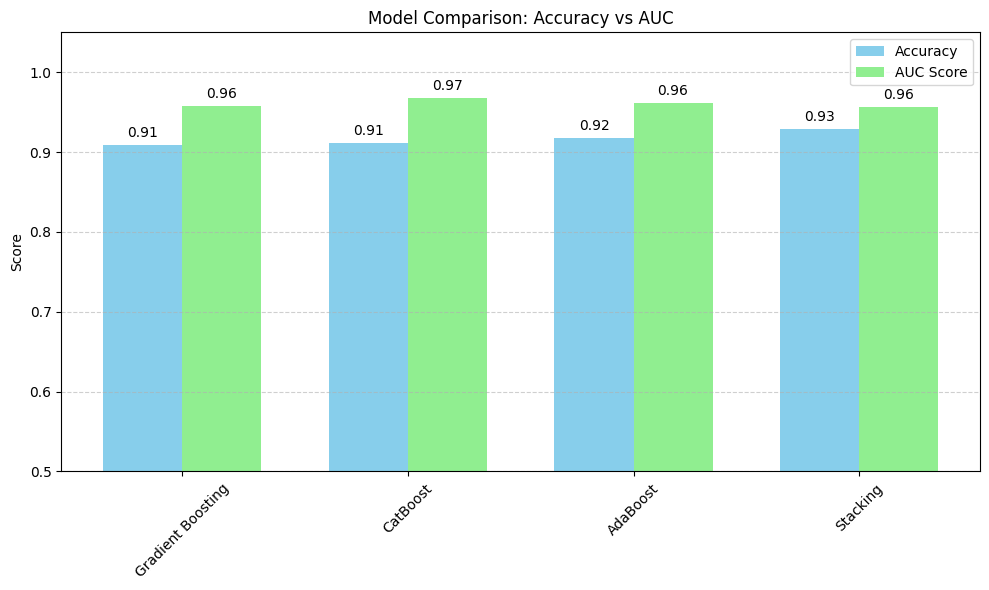

In [ ]:
# Unpack results
model_names = [name for name, _, _ in model_results]
accuracies = [acc for _, acc, _ in model_results]
aucs = [auc for _, _, auc in model_results]

# Set width and positions
x = np.arange(len(model_names))
width = 0.35

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, aucs, width, label='AUC Score', color='lightgreen')

# Labels and formatting
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs AUC')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0.5, 1.05)
plt.legend()

# Annotate bar values
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Save the figure to a file
plt.savefig('model_comparison.png', format='png')

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Containers
metrics_class_0 = {'Precision': [], 'Recall': [], 'F1': [], 'Support': []}
metrics_class_1 = {'Precision': [], 'Recall': [], 'F1': [], 'Support': []}
model_names = []
tooltip_info = []

# Loop over models
for name, model in model_dict.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Save metrics for each class
    for class_label, metrics in zip(['0', '1'], [metrics_class_0, metrics_class_1]):
        metrics['Precision'].append(report[class_label]['precision'])
        metrics['Recall'].append(report[class_label]['recall'])
        metrics['F1'].append(report[class_label]['f1-score'])
        metrics['Support'].append(report[class_label]['support'])

    model_names.append(name)

    # Add TP, FP, TN, FN for hover info
    tn, fp, fn, tp = cm.ravel()
    tooltip_info.append({
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn
    })

# Create figure
fig = go.Figure()

colors = {
    'Precision': '#1f77b4',
    'Recall': '#ff7f0e',
    'F1': '#2ca02c',
    'Support': '#9467bd'
}

# Class 0
for metric in metrics_class_0:
    fig.add_trace(go.Bar(
        name=f'Class 0 - {metric}',
        x=model_names,
        y=metrics_class_0[metric],
        marker_color=colors[metric],
        hovertext=[f"Class 0<br>{metric}: {v:.2f}" for v in metrics_class_0[metric]],
        hoverinfo='text'
    ))

# Class 1
for metric in metrics_class_1:
    fig.add_trace(go.Bar(
        name=f'Class 1 - {metric}',
        x=model_names,
        y=metrics_class_1[metric],
        marker_color=colors[metric],
        opacity=0.6,
        hovertext=[
            f"Class 1<br>{metric}: {v:.2f}<br>TP: {tooltip_info[i]['TP']}<br>FP: {tooltip_info[i]['FP']}<br>TN: {tooltip_info[i]['TN']}<br>FN: {tooltip_info[i]['FN']}"
            for i, v in enumerate(metrics_class_1[metric])
        ],
        hoverinfo='text'
    ))

# Layout
fig.update_layout(
    title='📊 Class-wise Metrics Comparison with Custom Tooltips',
    xaxis_title='Model',
    yaxis_title='Score / Count',
    barmode='group',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()


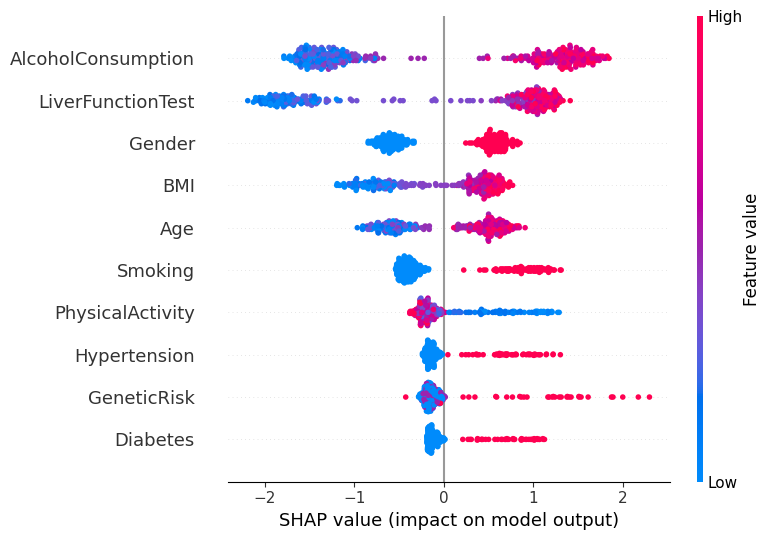

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap

# Initialize SHAP TreeExplainer for Gradient Boosting Classifier
explainer = shap.TreeExplainer(cat)  # 'cat' is the trained GradientBoostingClassifier model
shap_values = explainer.shap_values(X_test)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test)

# Save the SHAP summary plot as a PNG file
# Get the current figure and save it
import matplotlib.pyplot as plt
plt.savefig("shap_summary_plot.png", format="png")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names



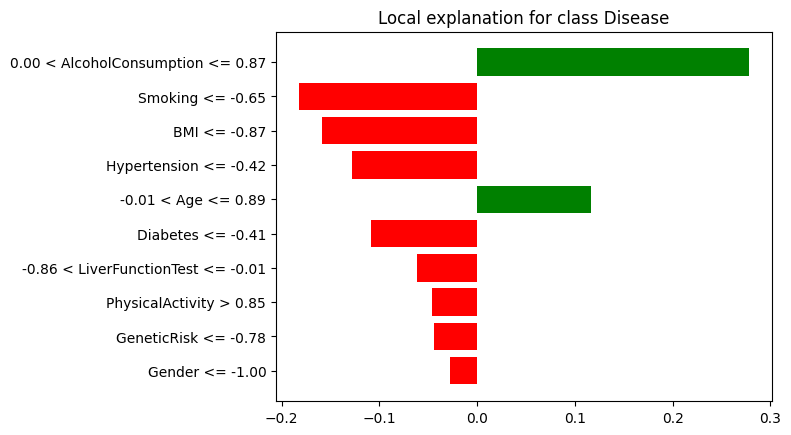

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train, X_test, and ensemble_model (your stacking model) are already defined and trained
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,                  # Training data for explainer
    mode='classification',                         # Classification mode
    feature_names=X_train.columns,                 # Feature names
    class_names=['No Disease', 'Disease'],         # Class labels (update as needed)
    discretize_continuous=True                     # For handling continuous features
)

# Randomly selecting a test instance to explain
idx = np.random.randint(0, X_test.shape[0])        # Select random index from test set

# Generate explanation for the selected test sample
exp = lime_explainer.explain_instance(
    data_row=X_test.values[idx],                   # Test instance to be explained
    predict_fn=stacking_model.predict_proba        # Function returning class probabilities
)

# Display explanation in notebook
exp.show_in_notebook()

# Save the explanation plot as a PNG image
fig = exp.as_pyplot_figure()  # Convert explanation to a matplotlib figure
fig.savefig("lime_explanation_plot.png", format="png", dpi=300)  # Save it as PNG


In [ ]:
import pickle

In [ ]:
# Save the trained models
pickle.dump(ada, open('adaboost_liver_model.sav', 'wb'))
pickle.dump(gbm, open('gradient_liver_boosting_model.sav', 'wb'))
pickle.dump(cat, open('catboost_liver_model.sav', 'wb'))
pickle.dump(stacking_model, open('stacking_liver_model.sav', 'wb'))

# Save the scaler for preprocessing during inference
pickle.dump(scaler, open('_liver_scaler.sav', 'wb'))